## Demo 2: Spin-domain simulation and gradient calculation for optimization

This notebook provides examples of how to simulate the RF pulse using spin-domain representations and using auto-differentiation to calculate the gradients (derivatives) for optimization. 

1. how to calculate derivatives using provided simulation function, `spinorsim`, which returns $(\alpha_{real},\alpha_{imag},\beta_{real},\beta_{imag})$
2. one simple example of optimizing RF waveforms 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
# sys.path.append('.../Multid_RF_SpinDomain/src') # may need to add your path 

In [2]:
# ------ select the device ------
# device = torch.device('cuda:0')    # if GPU is available
device = torch.device('cpu')       # CPU is still ok for this demo

In [ ]:
from sdrf import mri
from sdrf.mrsim import SpinDomain

### Spin-domain simulation and auto-differentiation

In [4]:
# Spins Object
spins = mri.SpinGrid(fov=[4,4,4],dim=[3,3,3],device=device)

# Example RF and gradient waveforms
# These are also the variables for which we want the derivatives  
Nt = 5
rf = torch.randn(2,Nt).to(device)  # mT
gr = torch.randn(3,Nt).to(device)  # mT/m
dt = 1e-2    # ms

# Enable the derivative
rf.requires_grad = gr.requires_grad = True
rf.grad = gr.grad = None

# Simulation in spin-domain
alpha_re,alpha_im,beta_re,beta_im = SpinDomain.spinorsim(spins, Nt=Nt, dt=dt, rf=rf, gr=gr, device=device)

# Example loss function, which return a real number
# here use an example loss function that sum the value of beta
loss = torch.sum(beta_re)

# Then with auto-differentiation, we can call derivative like any functions in pytorch
loss.backward()
print(rf.grad)
print(gr.grad)

tensor([[ 16.6081,  19.2049,  -6.5773, -24.1545, -19.8392],
        [-14.1863, -18.2531,  -8.1558,   1.1962, -13.7747]])
tensor([[ 0.0094,  0.0038,  0.0011, -0.0049, -0.0066],
        [-0.0007, -0.0026,  0.0004,  0.0029,  0.0017],
        [ 0.0045,  0.0022, -0.0006, -0.0046, -0.0035]])


### Simple example of pulse optimization
The following section we show a very simple example of calculating derivatives and optimize the RF waveform. 
This is mainly for demonstrating how to use the provided functions instead of really designing an RF pulse.
In practice, the initialization can be important. 

tensor(30.8129)
loss=30.812889099121094
loss=26.139535903930664
loss=10.205591201782227
loss=20.006881713867188
loss=36.52269744873047
loss=9.983704566955566
loss=9.60719108581543
loss=9.196784973144531
loss=8.292341232299805
loss=7.066058158874512
loss=4.400633811950684
loss=3.129276752471924
loss=1.6343661546707153
loss=0.700336754322052
loss=0.5388776063919067
loss=0.36801379919052124
loss=0.26672792434692383
loss=0.18916034698486328
loss=0.15573933720588684
loss=0.11873641610145569
loss=0.0846327543258667
loss=0.05023157596588135
loss=0.022852405905723572


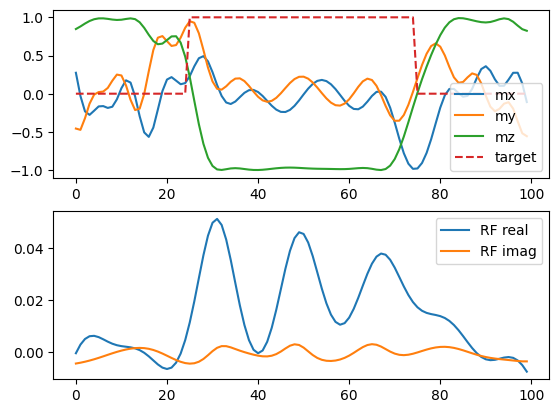

In [5]:
torch.manual_seed(0)

# Define spins that are located at different spatial locations 
spins = mri.SpinGrid(fov=[1,1,2],dim=[1,1,100])

# Define pulse
Nt = 100
dt = 4e-2

# Fix the gradient 
gr = torch.zeros(3,Nt).to(device)
gr[2] = 4.7 # mT/m

# initialize the rf waveform as some sinc shape
b1 = 6*1e-3*torch.special.sinc((torch.arange(Nt)-50)/25)
rf = torch.zeros(2,Nt)
rf[0] = b1
rf = rf.to(device)

# Define a target excitation profile
target = torch.zeros(100)
target[25:75] = 1

weight = torch.ones(100)
weight[20:30] = 0
weight[70:80] = 0

# Define a loss function 
def loss_fn(rf):
    a_r,a_i,b_r,b_i = SpinDomain.spinorsim(spins, Nt=Nt, dt=dt, rf=rf, gr=gr, device=device)
    
    # 180-degree
    para_real = b_r*b_r - b_i*b_i
    para_imag = 2*b_r*b_i
    errors = (para_real**2 + para_imag**2 - target)**2

    # 90-degree 
    # para_real = 2 * (a_r*b_r + a_i*b_i)
    # para_imag = 2 * (a_r*b_i - a_i*b_r)
    # errors = (para_real**2 + para_imag**2 - target)**2

    loss = torch.sum(errors * weight)
    return loss
print(loss_fn(rf))


# Optimization 
rf.requires_grad = True
rf.grad = None
optimizer = torch.optim.LBFGS([rf], lr=1.,line_search_fn='strong_wolfe')
def closure():
    optimizer.zero_grad()
    loss = loss_fn(rf)
    print('loss={}'.format(loss.item()))
    loss.backward()
    return loss
optimizer.step(closure)
rf.detach_()

# Simulation of optimized RF pulse
alpha,beta = SpinDomain.spinorsim_c(spins,Nt,dt,rf,gr,device=device)
fig = plt.figure()

ax = plt.subplot(211)
mxy = 2 * alpha.conj() * beta
mz = alpha.abs()**2 - beta.abs()**2
ax.plot(torch.real(mxy).cpu().numpy(), label='mx')
ax.plot(torch.imag(mxy).cpu().numpy(), label='my')
ax.plot(mz.cpu().numpy(),label='mz')
ax.plot(target.cpu().numpy(), label='target',ls='--')
ax.legend()

ax = plt.subplot(212)
ax.plot(rf[0].cpu().numpy(),label='RF real')
ax.plot(rf[1].cpu().numpy(),label='RF imag')
ax.legend()

plt.show()